In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


#### opening dataset file and visualizing video

In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

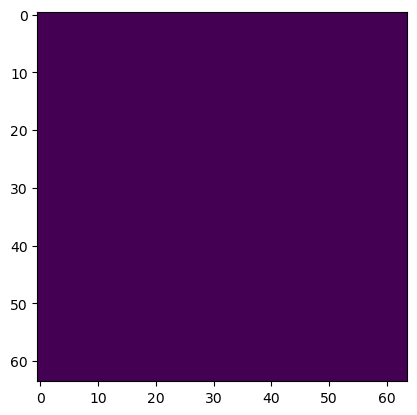

In [6]:
i = 100
pressure, signal = get_elemenst_from_dataset(slice(i, i+20))
pressure.shape, signal.shape
plt.imshow(pressure[0])
plt.show()

In [7]:
# for i in range(100, 200, 20):
#     pressure, signal = get_elemenst_from_dataset(slice(i, i+20), key_id=100)
#     pressure.shape, signal.shape
#     plt.imshow(pressure[0])
#     plt.show()

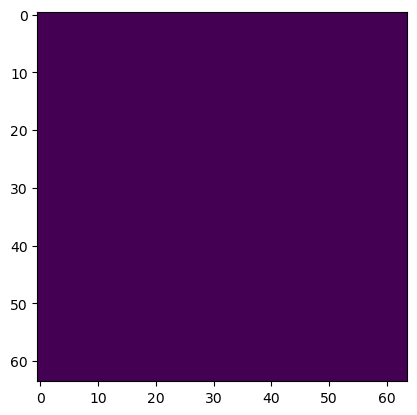

In [6]:
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
plt.imshow(pressure[0])
plt.show()

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

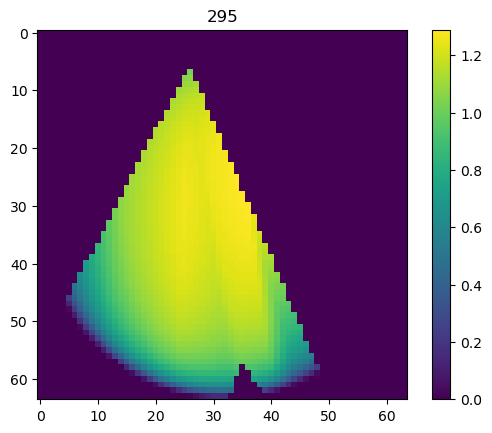

In [10]:
# for i in range(110, 300, 5):
#     clear_output(wait=True)
#     # n = 64*1+28
#     plt.imshow(pressure[i])
#     plt.title(f"{i}")
#     plt.colorbar()
#     plt.show()
#     time.sleep(0.5)


#### comparing simulation and saved results

In [15]:
# config['sim']['test_mod'] = True

In [6]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

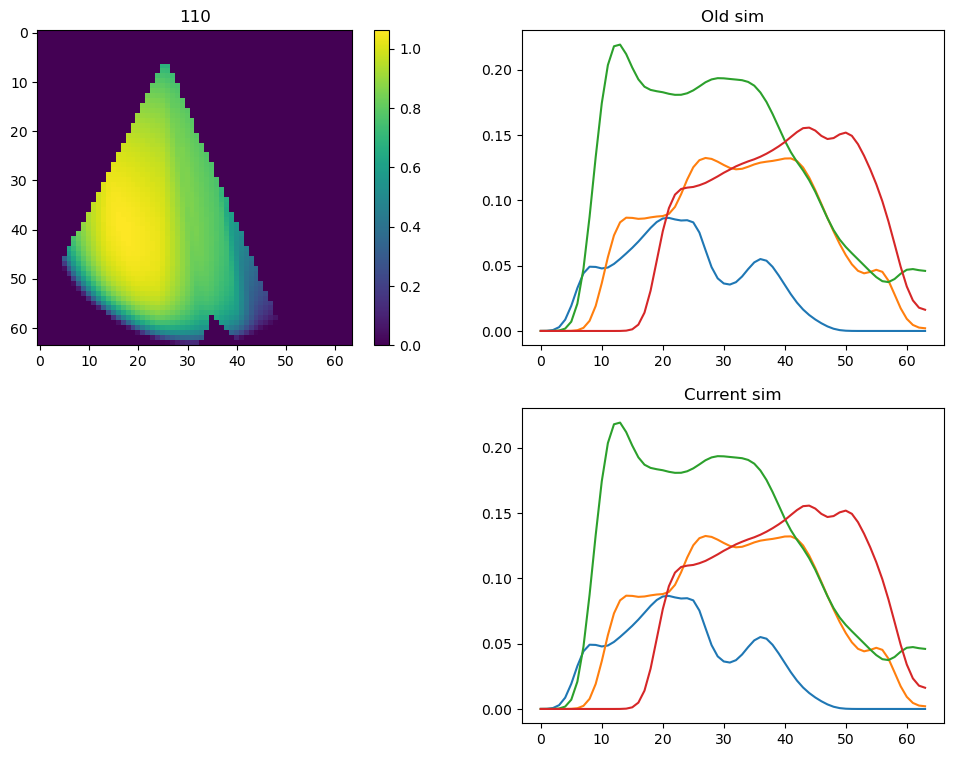

In [13]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 2, 4)
    plt.plot(sim.fiber_real_sim(pressure[i])[0].T)
    plt.title("Current sim")
    plt.show()
    time.sleep(0.5)

### comparing predictions

In [7]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

In [8]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [9]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

print(model)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)
ParamUnet(
  (step1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (finalConv): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
  (bottom): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
    (1): Sequential(
   

In [10]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

In [11]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

#### Закончил играться. Теперь делаю нормальную функцию.

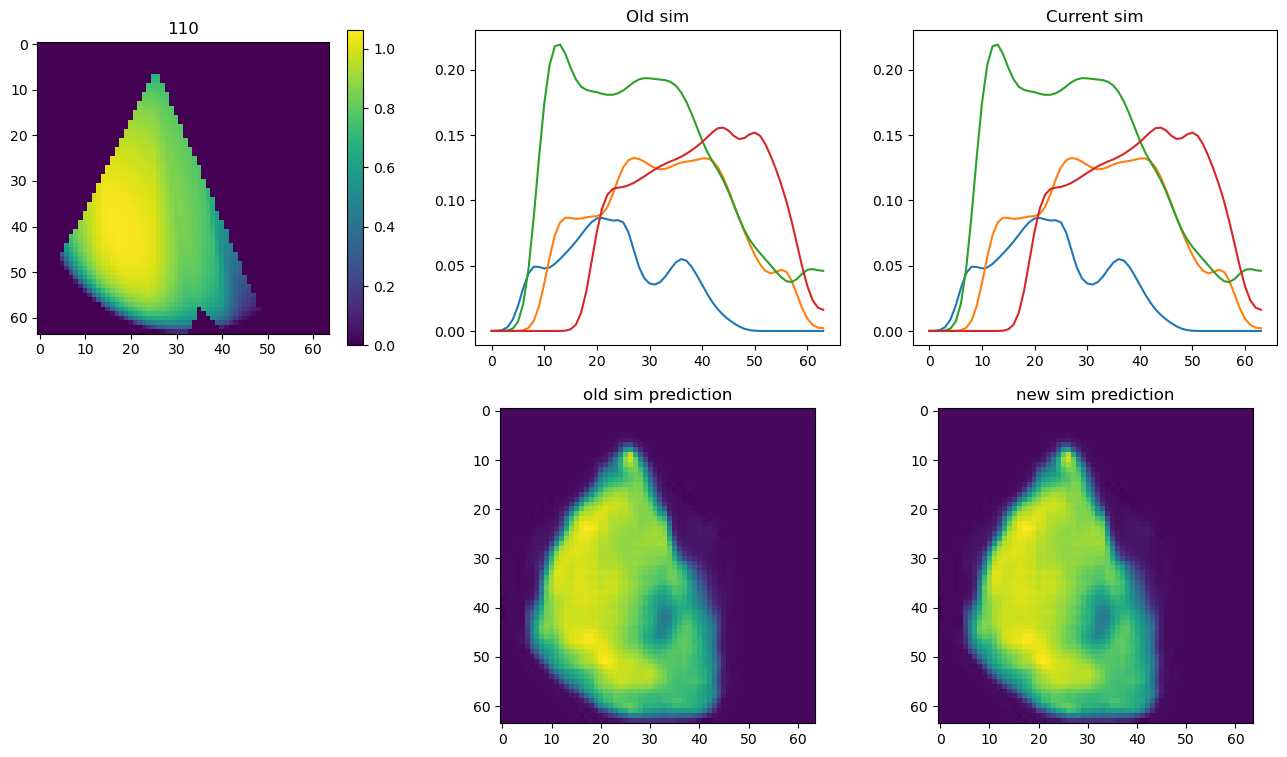

In [22]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

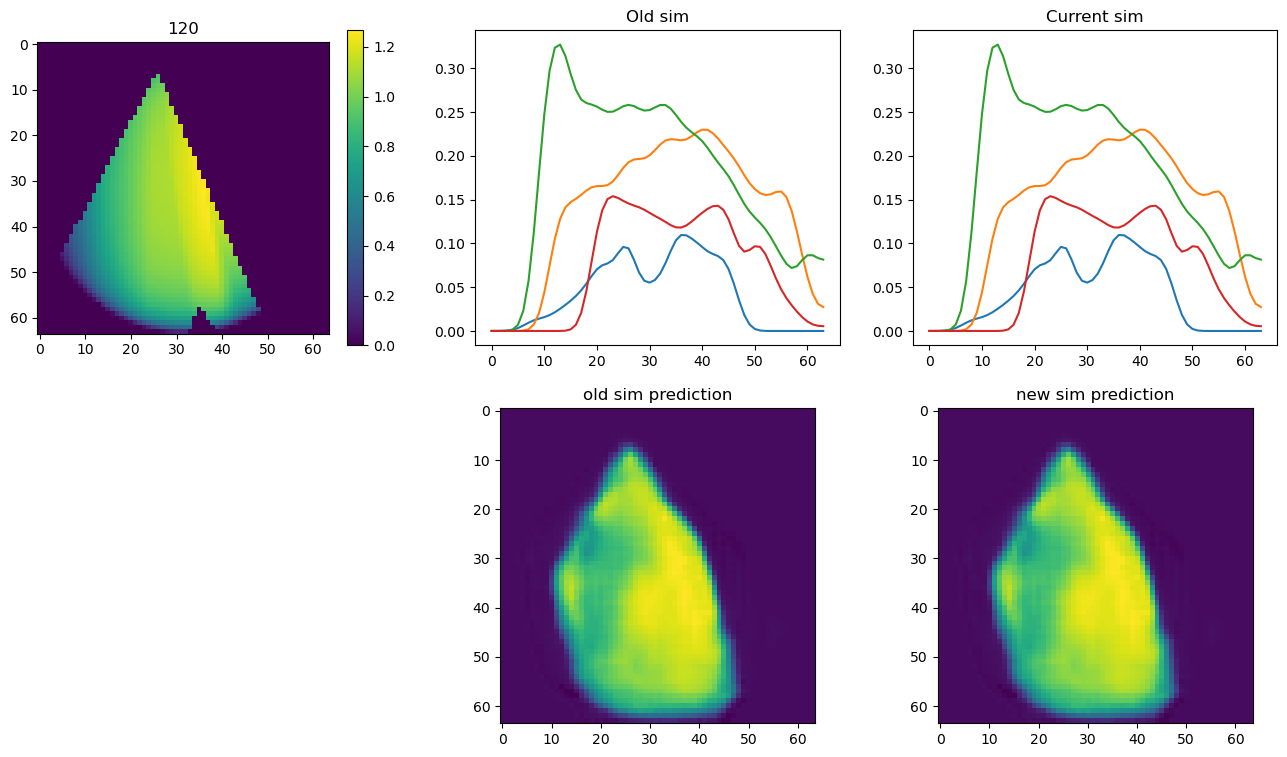

In [24]:

for i in range(60, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

#### Сделал в симуляции блюр задаваемым в мм-ах

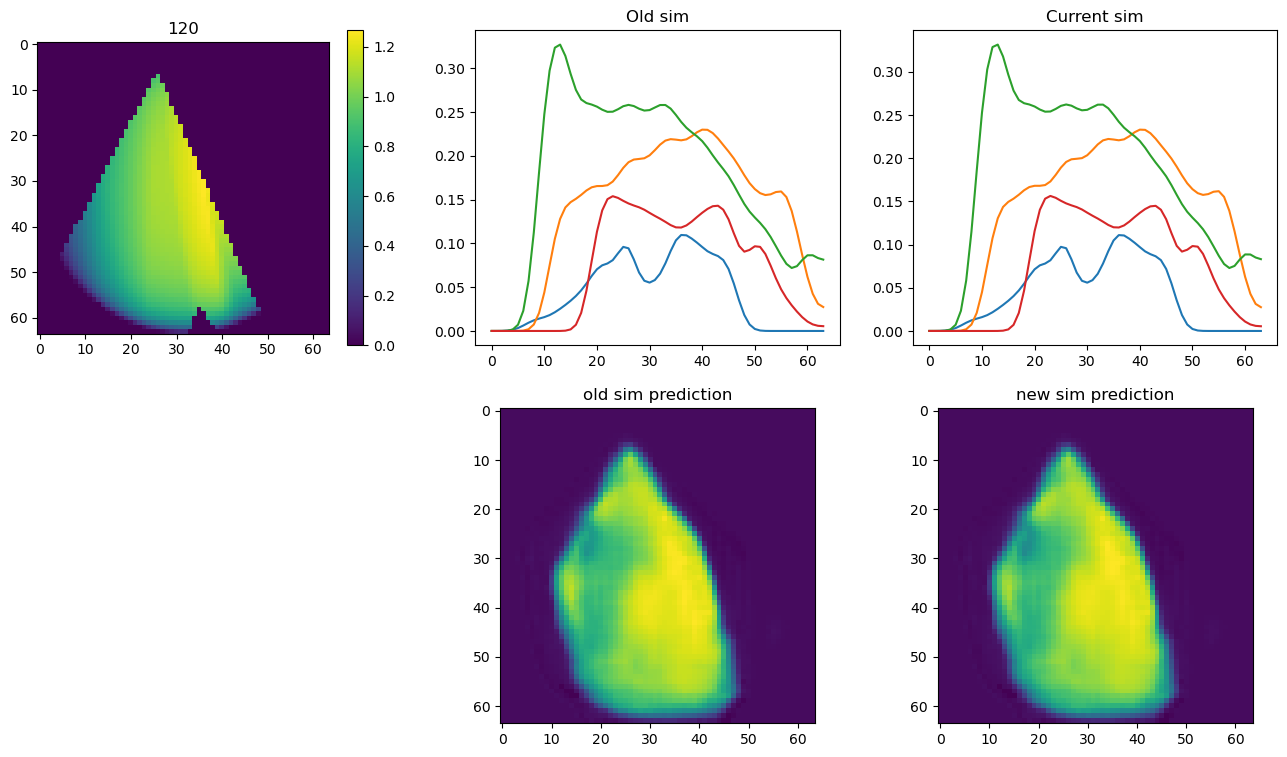

In [27]:

for i in range(60, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### Меняю симуляцию пропускания

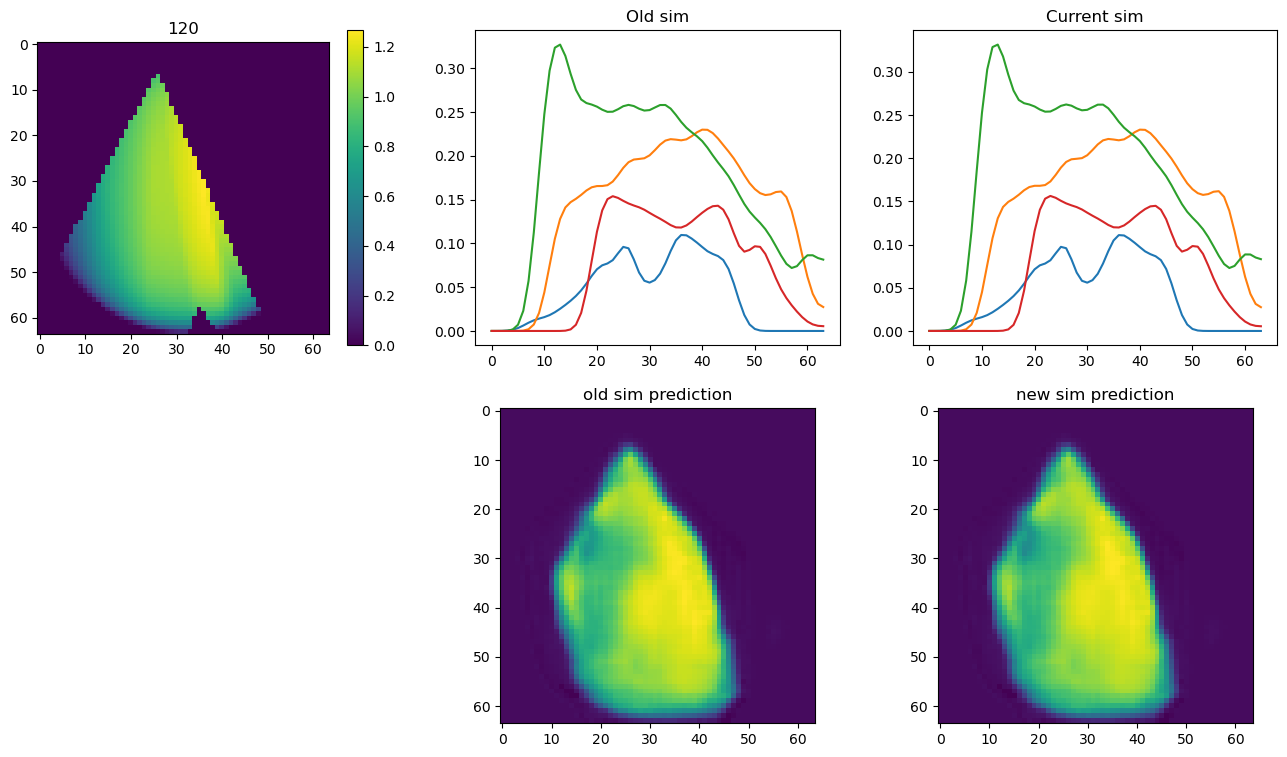

In [34]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

#### Перешел от умножений пропускания к суммированию экспаненциального показателя по волокну.

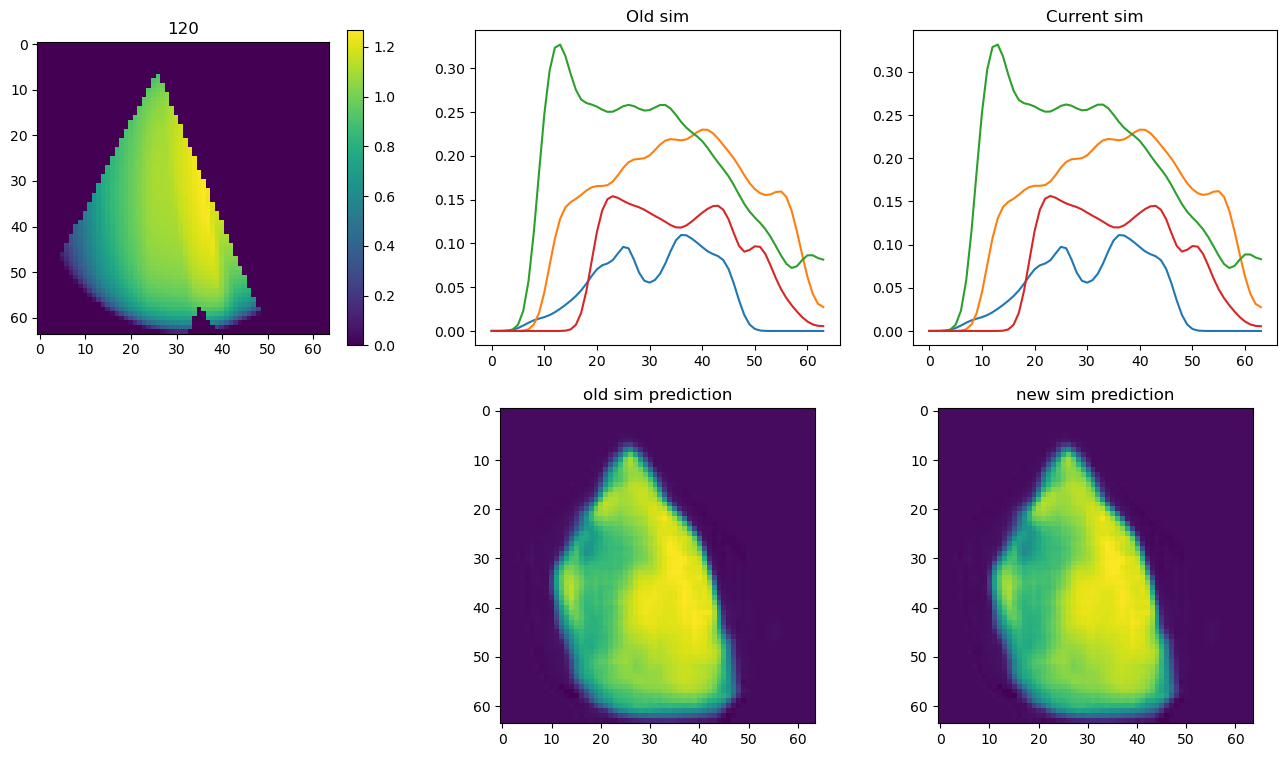

In [16]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### меняю аналитическую функцию на интерполяционную

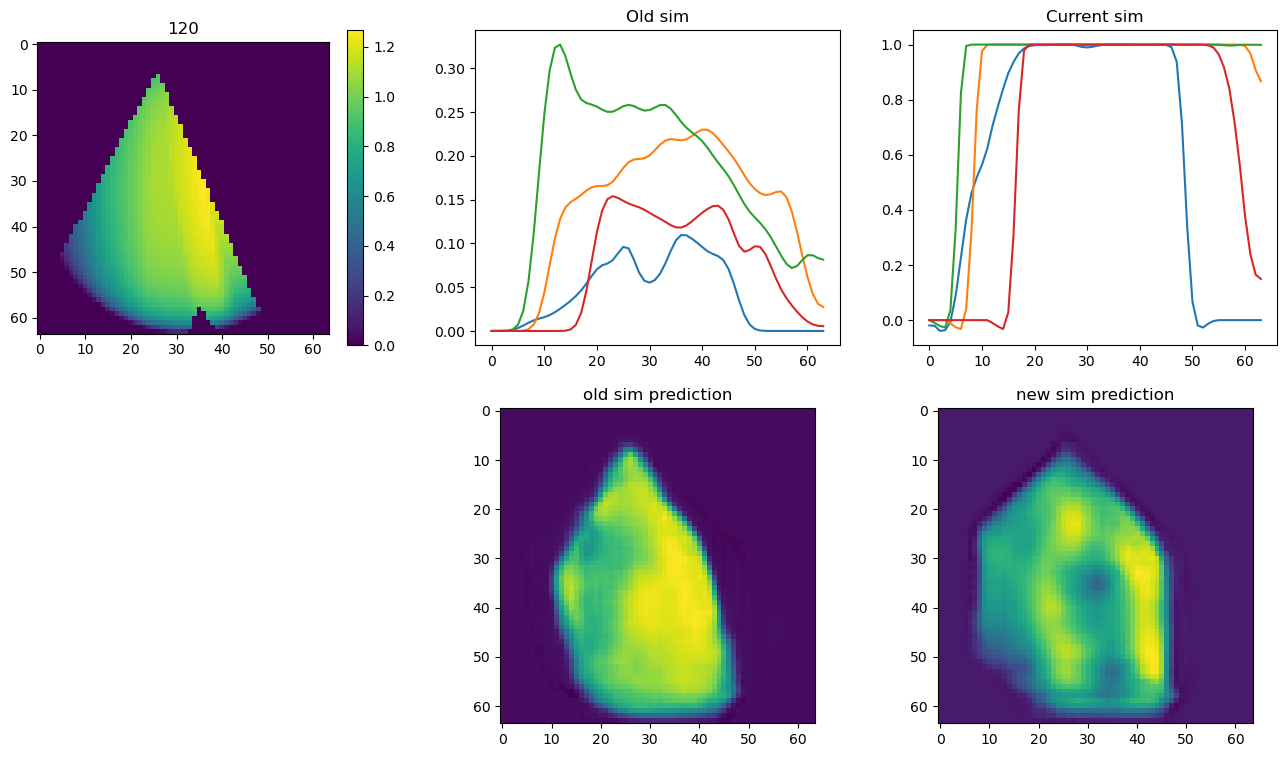

In [33]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

##### Вторая попытка

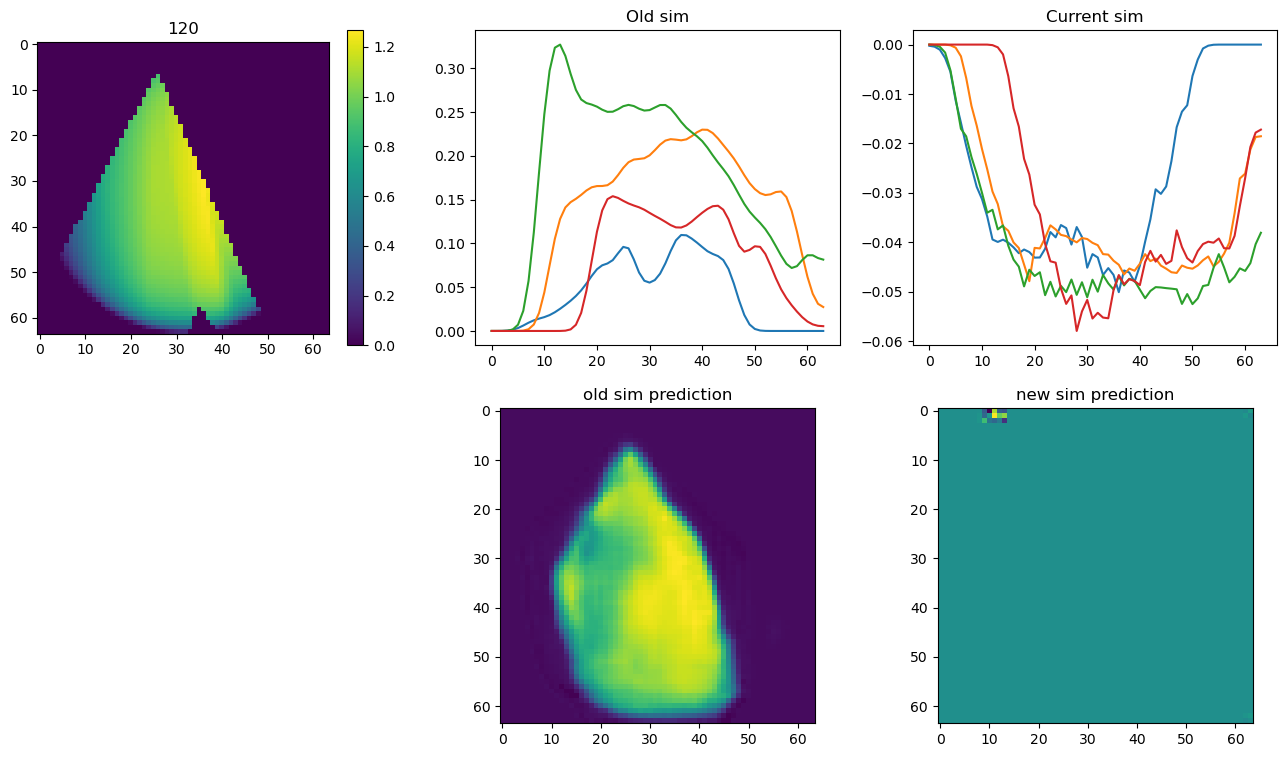

In [35]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

##### Третья попытка

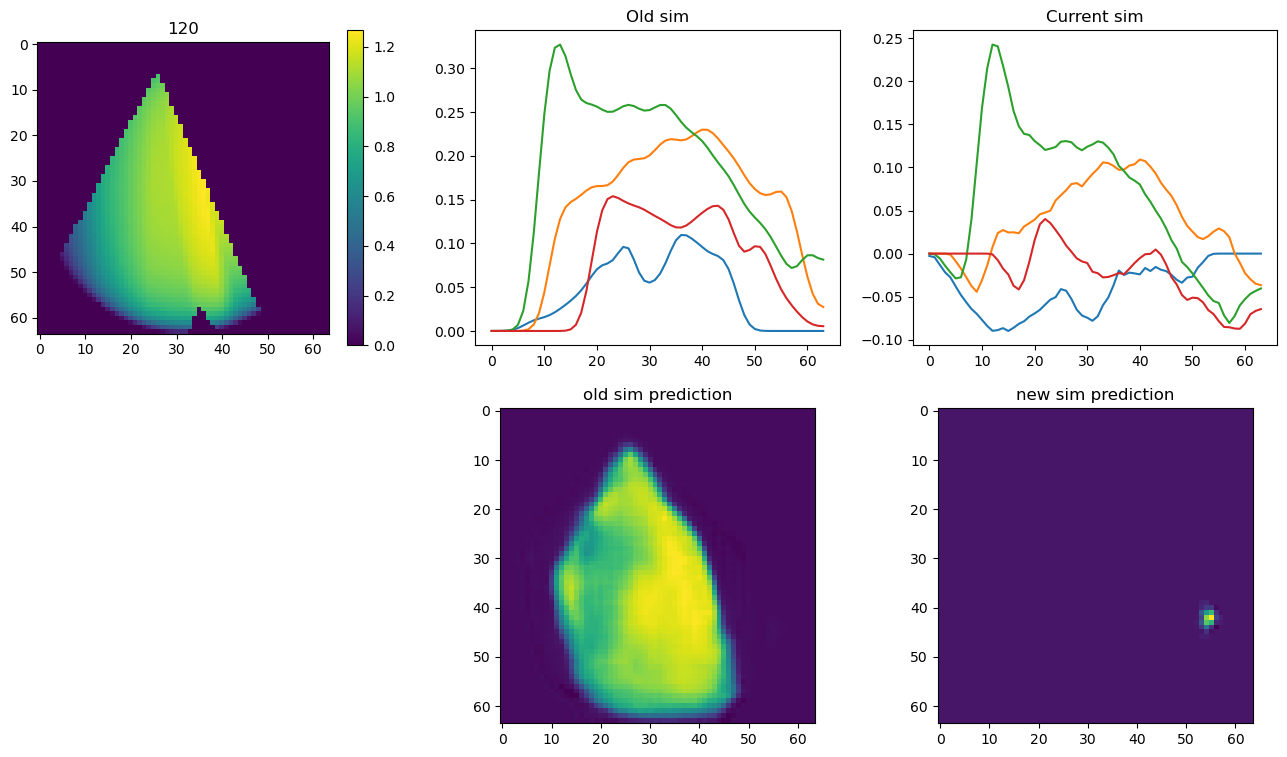

In [41]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    plt.show()
    time.sleep(0.5)


##### пытаюсь прямо отсуюда сравнить две эти функции потерь

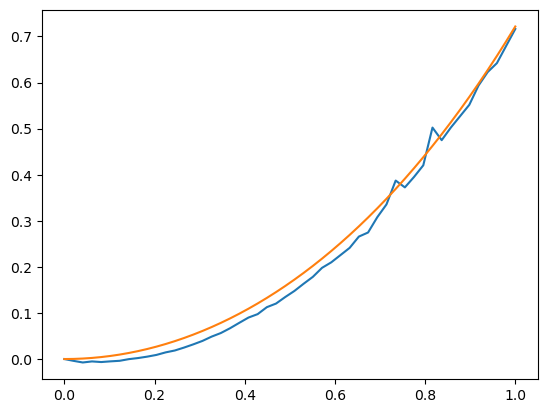

In [43]:
x = torch.from_numpy(np.linspace(0, 1))
y = sim._loss_coeff_function(x)
plt.plot(x, y)
y2 = -torch.log(sim._trans_fun(x))/sim.pixel_distance
plt.plot(x, y2)

#### Восстанавилваю по такой симуляции пропускание про точечном давлении. Проверяя таким образом корректность приближения

In [16]:
point_pres = torch.zeros((64, 64))
point_pres[31, 31] = 1

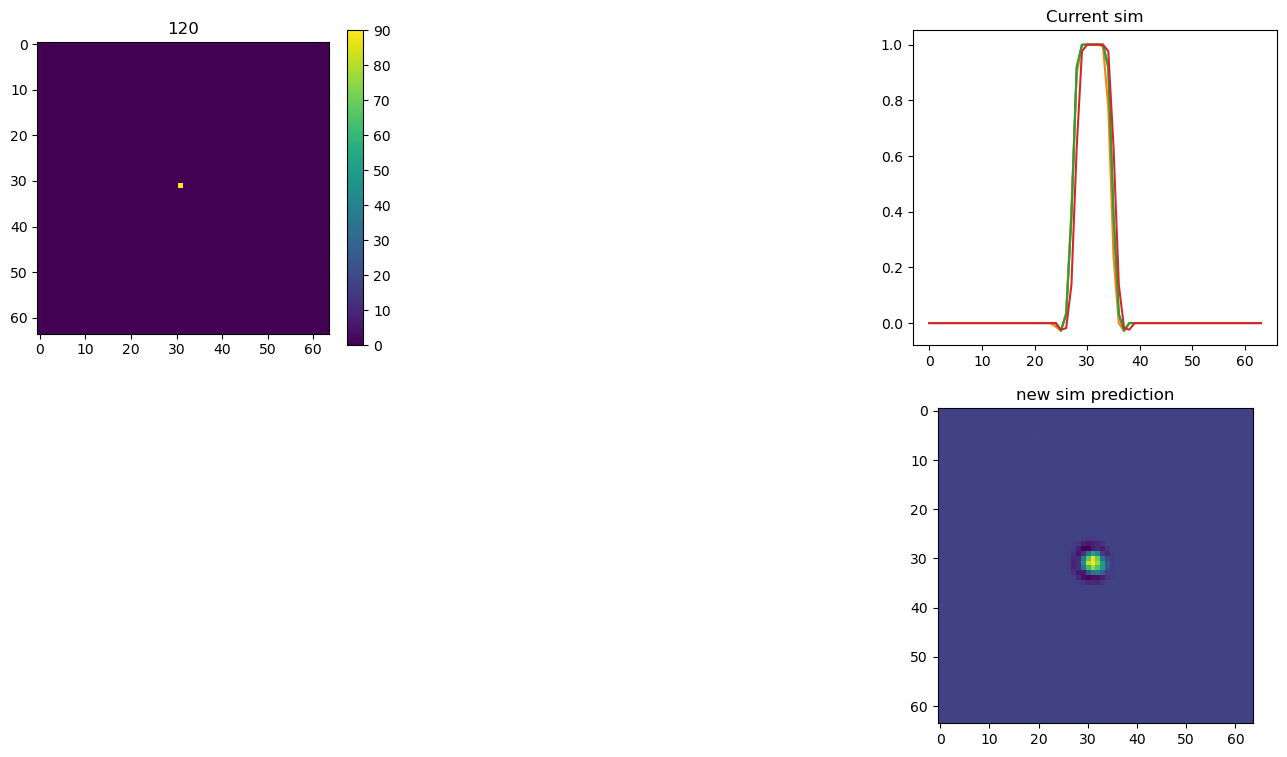

In [19]:

for alpha in range(10, 60, 10):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(point_pres*alpha)
    plt.title(f"{i}")
    plt.colorbar()
    
    # plt.subplot(2, 3, 2)
    # plt.plot(signal[i].T)
    # plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(point_pres*alpha)
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    # plt.subplot(2, 3, 5)
    # map = predict(model, signal[i:i+1], device)
    # plt.imshow(map[0])
    # plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

In [29]:
x = np.linspace(0, 60, 200)
y = []
for alpha in x:
    new_signal = sim.fiber_real_sim(point_pres*alpha)
    y.append(new_signal[0][0][31])
y = np.array(y)

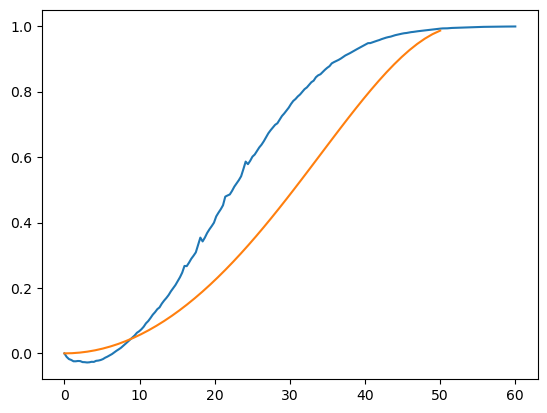

In [30]:
plt.plot(x, y)

x2 = torch.from_numpy(np.linspace(0, 2.5))
y2 = 1-sim._trans_fun(x2)
plt.plot(x2*50/2.5, y2)

In [31]:
y.min()

-0.027831316